# Plant pathology 2020

# Setting up env and downloading dataset

In [1]:
import os
from pathlib import Path

def check_environment() -> bool:
    """Check if the notebook is running in Google Colab or not.

    Returns:
        bool: True if running in Colab, False otherwise.
    """
    return bool(os.getenv("COLAB_RELEASE_TAG"))

def download_utils(colab_flag):
  """Function to clone the required utils .py helper module if running in colab

  Returns:
    None
  """
  if colab_flag:
    !curl -o /content/setup_utils.py https://raw.githubusercontent.com/jalkestrup/fastai_course/main/10_final_project/setup_utils.py
  else:
    return


In [2]:
colab_flag = check_environment()
download_utils(colab_flag)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3017  100  3017    0     0  10629      0 --:--:-- --:--:-- --:--:-- 10660


In [3]:
#Helper functions for setting up the environment and downloading the dataset based on compute environment
from setup_utils import install_libraries, download_kaggle_data, set_kaggle_credentials

install_libraries(colab_flag)

set_kaggle_credentials(colab_flag)

kaggle_dataset = 'plant-pathology-2020-fgvc7'
download_kaggle_data(kaggle_dataset)

Running in Colab...
...Installed required dependencies
Mounted at /content/drive/
Sucesfully set kaggle credentials
Data not detected, starting download


100%|██████████| 779M/779M [00:10<00:00, 80.5MB/s]


# Inspecting the data

In [4]:
import timm
from fastai.vision.all import *

path = Path('plant-pathology-2020-fgvc7')

image_path = path/'images'
image_files = get_image_files(image_path)

Shape of image : (1365, 2048)


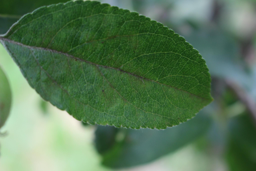

In [5]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

The images are of similar size (1365 x 2048), but a few are rotated (2048x1365). To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.



## Loading resized images
From previous script I have resized the images to 266x400 size, and saved them on Google Drive. We load these for experimentation

In [6]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

Number of cores 2


In [7]:
"""
dest = path/'small_images'
resize_images(path/'images', max_size=400, dest=dest, recurse=True)

#Save resized images to drive for fast reload in new instance
Copy images from path/small_images to /content/drive/MyDrive/dtu/fastAI/10_final_project
!cp -r '/content/plant-pathology-2020-fgvc7/small_images' /content/drive/MyDrive/dtu/fastAI/10_final_project
"""
#Copy prev resized images from drive to Colab
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
if colab_flag == True:
    !mkdir /content/plant-pathology-2020-fgvc7/small_images
    !cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/small_images/. '/content/plant-pathology-2020-fgvc7/small_images'
    #Check the size of a photo in the small_images
    image_path_small = path/'small_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()
else:
    #For local dev (no GPU) make tiny images for faster training
    dest = path/'tiny_images'
    if not os.path.exists(dest):
        os.mkdir(dest)
        resize_images(path/'images', max_size=128, dest=dest, recurse=True)
    image_path_small = path/'tiny_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()


## Setting up labels

In [8]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [9]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [10]:
df_train.label.value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

# Model experimentation

In [11]:
#Function for collecting and emptying GPU Cache

if colab_flag:
    !pip install pynvml
    import gc
    def report_gpu():
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

    report_gpu()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
GPU:0
no processes are running


## Model evaluation
**Metric**
According to kaggle competition, the score is "evaluated on **mean column-wise ROC AUC**", however as RoCAuC cannot be differentiated we can not use this as our loss function. ROC AUC is generally robust towards class-imbalance (predicting 99% as yellow if 99.5% of samples was yellow would not yield a good result).

RoCAuC can be added as a metric via FastAi, and the default setting of RocAuC is (axis=-1, average=macro, multi_glass=ovr) which matches the intention of the competition.

**Loss function**
Default for of the vision learner for categorical variables, is **CrossEntropy**. Discussions seem to be that **Dice score** could perform better for optimizing RoCAuC than CrossEntropy, but it seems not always to hold true https://forums.fast.ai/t/using-auc-as-metric-in-fastai/38917 . Another option is to apply

~~ **Focal Loss** that is a modification of cross entropy loss that scales the loss relative to confidence so that "easy examples" are automatically down-weighted https://paperswithcode.com/method/focal-loss . Tested out a few runs, performs very poorly. Further reading states "Focal loss is specialized for object detection with very unbalance classes" and might not be suitable for this task https://discuss.pytorch.org/t/focal-loss-performs-worse-than-cross-entropy-loss-in-clasification/139312/3 ~~

**Unbalanced dataset**
As previously noted the dataset is highly inbalanced in terms of the multiple_diseases label that only has about 1/6 of samples that the other labels.

For CV tasks it seems like there are varied opinions on whether an inbalance of this scale negatively impacts training and performance of the model, https://forums.fast.ai/t/handling-class-imbalance-in-deep-learning-models/33054/2 ,  but a few methods to deal with inbalances are:


*   Oversampling, taking more samples from the multi_disease labeled images during training
*   Unddersampling, taking fewer samples from the other labels during training (not a good option in our case as our training set is already small)
*   Weighting the loss function according to the inverse proportion of class frequency to emphasize loss from under represented samples




## Setting up W&B and model function

In [12]:
if colab_flag:
    !pip install -Uq wandb
    #Silence Wandb printouts
    os.environ["WANDB_SILENT"] = "true"
    import wandb
    wandb.login()
else:
    !wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

**Note to self on normalization** It is common to normalize the image data prior training, something that is even more important when using pretrained models. When using pretrained models the normalization should be based on the same statistics that the model was trained on. Using the Visionlearner from FastAI automatically take care of normalization, typically just based on ImageNet statistics.
```

In [13]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
from fastai.callback.wandb import *
from fastai.metrics import RocAuc

def train_model(arch, item, batch, epochs, batch_size=64, learning_rate=0.005, accum_steps=1, wandb_flag=False):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  }

  if wandb_flag:
    wandb.init(project='apple_disease', entity='jealk', group='model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )

  learn = vision_learner(dls, arch, metrics=RocAuc(), pretrained=True, loss_func=CrossEntropyLossFlat()).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

  callbacks = [early_stopping_cb]
  if wandb_flag:
    callbacks.append(WandbCallback(log=None,log_preds=False,log_model=False))

  if accum_steps > 1:
    gradient_accumulation_cb = GradientAccumulation(accum_steps)
    callbacks.append(gradient_accumulation_cb)

  learn.fine_tune(epochs,learning_rate, cbs=callbacks)

  if wandb_flag:
    wandb.finish()

  return learn, dls

In [14]:
arch = 'vit_small_patch16_224.augreg_in21k_ft_in1k'

learn,dls = train_model(arch,
                        item=Resize(256, method='crop'),
                        batch=aug_transforms(size=224, min_scale=0.75),
                        epochs=30,
                        wandb_flag=False)
report_gpu()

epoch,train_loss,valid_loss,roc_auc_score,time
0,1.269369,0.579133,0.927864,00:17


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.414786,0.358604,0.950111,00:11
1,0.342475,0.287433,0.957199,00:12
2,0.314303,0.231756,0.965059,00:12
3,0.255854,0.201325,0.971989,00:13
4,0.220615,0.188481,0.975781,00:11
5,0.194780,0.188709,0.979149,00:10
6,0.161599,0.197073,0.977632,00:11
7,0.148414,0.250072,0.970555,00:17


No improvement since epoch 4: early stopping
GPU:0
process      16221 uses     3904.000 MB GPU memory


24 epochs and 4 min to reach RoC of 0.829477	By use of FocalLoss
22 epochs and 4 min to reach RoC of 0.925 By use of FocalLoss
~~... Very strange, after reverting back to regular CrossEntropy loss the training is not equally poor! Prior this the valid loss always converged within 10 epochs and reached a loss around 0,15-0,25, now after changing back and rerunning several times we are going upwards 20-30 epochs before reaching a plateau and the results are much worse around 0,4-0,5 validation loss. I have now specified fine_tune and loss function explicitly to ensure that the default values are used again, but yet the poor performance prevails - WHHAAAAT is going on??~~

Restartet the instance and re-ran all, now it is back to normal.. Super strange



In [15]:
report_gpu()

GPU:0
process      16221 uses     1784.000 MB GPU memory


# Predicting on test set

In [48]:
#Load the list of test images into a pandas dataframe
df_test = pd.read_csv(f'{path}/test.csv')
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


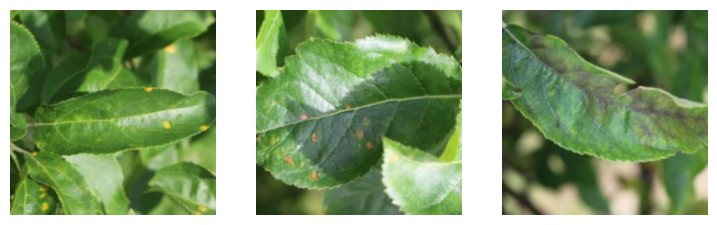

In [49]:
#Load the test images into a dataloader
test_dl = dls.test_dl(df_test)
test_dl.show_batch(max_n=3)

### Predictions using TTA
 test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image, in order to improve accuracy. Increases inference time by factor N, where N is the number of augmented versions created.

 **Regular prediction**


In [ ]:
#preds,_ = learn.get_preds(dl=test_dl)

### TTA prediction

In [50]:
preds,_ = learn.tta(dl=test_dl, n=4)

# Creating and submitting CSV to kaggle

In [51]:
#Append pd.DataFrame(preds) to the df_test dataframe
df_test = pd.concat([df_test, pd.DataFrame(preds)], axis=1)

#Set the column names to that of df_train labels
df_test.columns = df_train.columns[:5]
df_test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.054750,0.014576,0.878021,0.052653
1,Test_1,0.054400,0.018973,0.765417,0.161210
2,Test_2,0.022178,0.034076,0.016480,0.927266
3,Test_3,0.784783,0.002969,0.006014,0.206234
4,Test_4,0.004066,0.009652,0.981274,0.005008


In [52]:
#Create a csv file of the dataframe without the index column and save it on the root folder
df_test.to_csv('submission.csv', index=False)

In [54]:
from kaggle import api

api.competition_submit_cli('submission.csv', 'focal_point_256_to_vit_small_patch16_224_tta', kaggle_dataset)

100%|██████████| 95.6k/95.6k [00:02<00:00, 40.1kB/s]


Successfully submitted to Plant Pathology 2020 - FGVC7